<a href="https://colab.research.google.com/github/zabihin/CT-Image-Classification/blob/main/CT_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1-Data collection (data (from kaggle ) is stoted in Google drive
2-Data Preprocessing (Image Data Augmentation and Rescaling)
3-Build a model (select base model, select optimizer ,..)
4-Compile the model 
5-Fine Tuning
6-Explain
 

#Data collection
 !pip install -q kaggle

! mkdir ~/.kaggle/

!cp '/content/drive/MyDrive/Kaggle/kaggle.json' ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d mohamedhanyyy/chest-ctscan-images

!unzip /content/chest-ctscan-images.zip -d CT-data;

In [ ]:
#Importing
import os
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

tf.__version__

'2.8.2'

#Load the data

In [ ]:
#load data
data_path='/content/drive/MyDrive/Kaggle/CT-data/Data'

In [ ]:
#Specify the folder path
train_dir=os.path.join(data_path,'train')
test_dir=os.path.join(data_path,'test')
valid_dir=os.path.join(data_path,'valid')


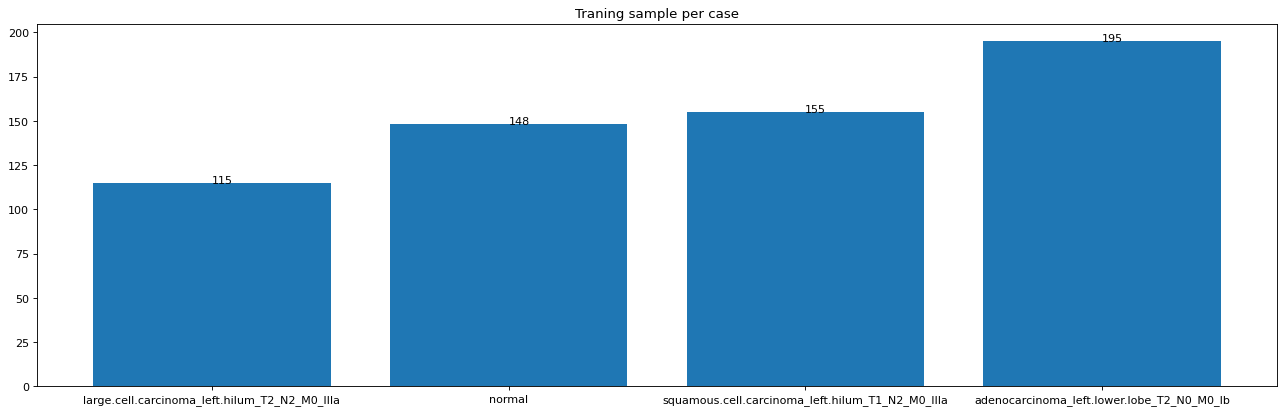

In [ ]:
folder = '/content/drive/MyDrive/Kaggle/CT-data/Data/train'
#find the each catagory sample size and plot it
label_name = [name for name in os.listdir(folder) ]
label_count=[len(os.listdir(folder+'/'+name)) for name in os.listdir(folder)]
res = dict(zip(label_name, label_count))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],y[i])

figure(figsize=(20, 6), dpi=80)
plt.bar(label_name,label_count)
 # making the bar chart on the data
addlabels(label_name, label_count)
# giving title to the plot
plt.title("Traning sample per case")
plt.show()


In [ ]:
#if we guess by random, what is raw probability
prob_dict = {}
for k, v in res.items():
    prob_dict[k] = v / sum(res.values())

print(prob_dict)

{'large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa': 0.18760195758564438, 'normal': 0.24143556280587275, 'squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa': 0.2528548123980424, 'adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib': 0.3181076672104405}


#Data Preprocessing


In [ ]:
img_generator_train = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
      rotation_range=5,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

img_generator_valid = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                  validation_split = 0.2)

img_generator_test  = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255
                                  )

In [ ]:
img_generator_flow_train = img_generator_train.flow_from_directory(
    directory=train_dir,
    target_size=(350, 350),
    batch_size=64,
    shuffle=True,
    class_mode='categorical')
img_generator_flow_valid = img_generator_valid.flow_from_directory(
    directory=valid_dir,
    target_size=(350, 350),
    batch_size=64,
    shuffle=True,
    class_mode='categorical')

img_generator_flow_test = img_generator_test.flow_from_directory(
    directory=valid_dir,
    target_size=(350, 350),
    batch_size=64,
    shuffle=True,
    class_mode='categorical')

Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


#Bulid Model

### Base Model Selecting



Based on this article "Transfer learning for medical image classification: a literature review"
The investigated studies demonstrated the efficacy of transfer learning despite the data scarcity. We encourage data scientists and practitioners to use deep models (e.g. ResNet or Inception) as feature extractors, which can save computational costs and time without degrading the predictive power.

Kim, H.E., Cosa-Linan, A., Santhanam, N. et al. Transfer learning for medical image classification: a literature review. BMC Med Imaging 22, 69 (2022). https://doi.org/10.1186/s12880-022-00793-7

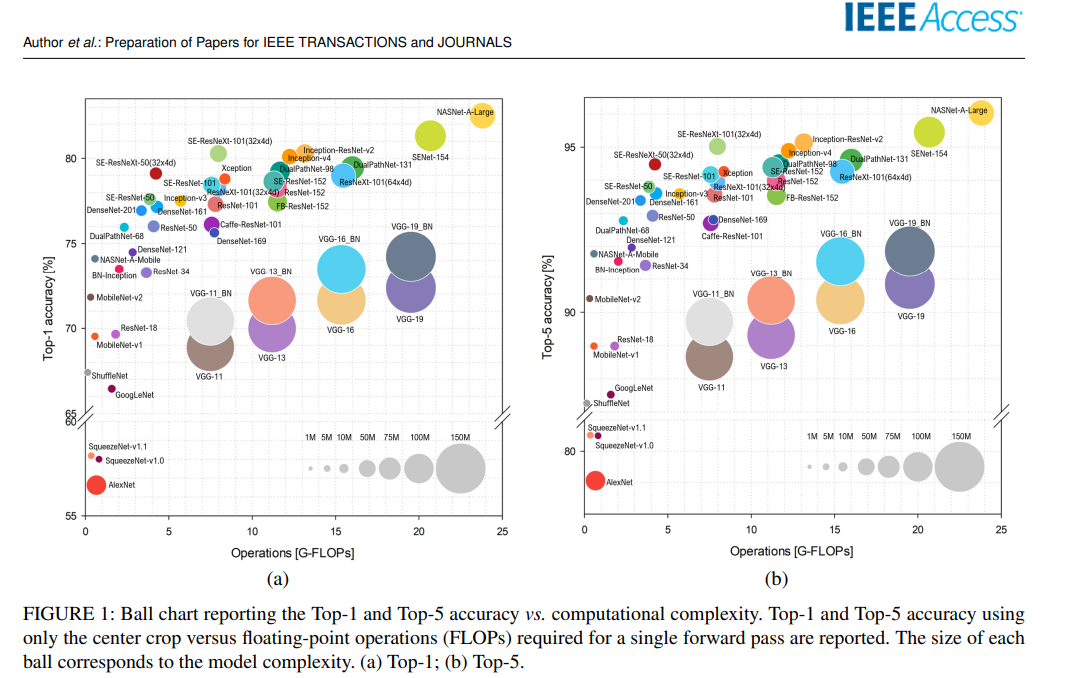

I will try Resnet101v2 and xception

1-Resnet101v2

In [ ]:
base_model = tf.keras.applications.ResNet101V2(input_shape=(350,350,3),
                                               include_top=False,
                                               
                                               )
base_model.trainable = False

In [ ]:
base_model.summary()


Model: "resnet101v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 350, 350, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 356, 356, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 175, 175, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation="softmax")
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101v2 (Functional)    (None, 11, 11, 2048)      42626560  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 2048)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 4)                 204804    
                                                                 
Total params: 42,831,364
Trainable params: 204,804
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
history=model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid,  steps_per_epoch=10, epochs=30)


Epoch 1/30
10/10 [==============================] - 35s 2s/step - loss: 9.9542 - categorical_accuracy: 0.3458 - val_loss: 3.2955 - val_categorical_accuracy: 0.5694
Epoch 2/30
10/10 [==============================] - 21s 2s/step - loss: 5.2547 - categorical_accuracy: 0.5579 - val_loss: 3.1216 - val_categorical_accuracy: 0.6111
Epoch 3/30
10/10 [==============================] - 21s 2s/step - loss: 3.1594 - categorical_accuracy: 0.6427 - val_loss: 3.7291 - val_categorical_accuracy: 0.5556
Epoch 4/30
10/10 [==============================] - 22s 2s/step - loss: 2.3732 - categorical_accuracy: 0.7096 - val_loss: 2.7832 - val_categorical_accuracy: 0.6667
Epoch 5/30
10/10 [==============================] - 21s 2s/step - loss: 1.8100 - categorical_accuracy: 0.7357 - val_loss: 2.0585 - val_categorical_accuracy: 0.6806
Epoch 6/30
10/10 [==============================] - 21s 2s/step - loss: 1.7034 - categorical_accuracy: 0.7602 - val_loss: 2.1765 - val_categorical_accuracy: 0.6667
Epoch 7/30
10/10

In [ ]:
model.save("/content/CT-v1.h5")

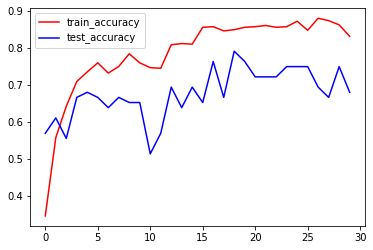

In [ ]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

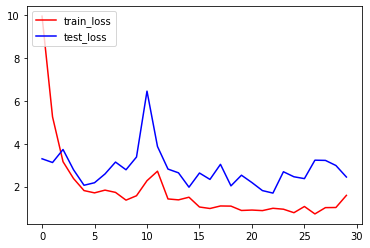

In [ ]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

#Fine Tuning


In [ ]:
len(base_model.layers)

377

In [ ]:
base_model = tf.keras.applications.ResNet101V2(input_shape=(350,350,3),
                                               include_top=False,
                                               
                                               )

In [ ]:
base_model.trainable = True

set_trainable = False
for layer in base_model.layers:
    if layer.name == 'conv5_block1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [ ]:
base_model.trainable = True
fine_tune_at = len(base_model.layers) - 30
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate =1e-5),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
history=model.fit(img_generator_flow_train, validation_data=img_generator_flow_valid, steps_per_epoch=10, epochs=50)


Epoch 1/50
10/10 [==============================] - 28s 2s/step - loss: 1.1252 - categorical_accuracy: 0.8597 - val_loss: 2.1789 - val_categorical_accuracy: 0.7222
Epoch 2/50
10/10 [==============================] - 21s 2s/step - loss: 0.7813 - categorical_accuracy: 0.8874 - val_loss: 2.0415 - val_categorical_accuracy: 0.7361
Epoch 3/50
10/10 [==============================] - 21s 2s/step - loss: 0.6857 - categorical_accuracy: 0.8972 - val_loss: 1.9944 - val_categorical_accuracy: 0.7361
Epoch 4/50
10/10 [==============================] - 21s 2s/step - loss: 0.9191 - categorical_accuracy: 0.8907 - val_loss: 2.0188 - val_categorical_accuracy: 0.7778
Epoch 5/50
10/10 [==============================] - 21s 2s/step - loss: 0.6078 - categorical_accuracy: 0.8940 - val_loss: 2.0138 - val_categorical_accuracy: 0.7778
Epoch 6/50
10/10 [==============================] - 21s 2s/step - loss: 0.7108 - categorical_accuracy: 0.9005 - val_loss: 2.0021 - val_categorical_accuracy: 0.7778
Epoch 7/50
10/10

In [ ]:
model.save("/content/CT-v2.h5")

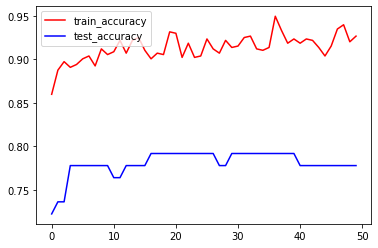

In [ ]:
# Visualise train / Valid Accuracy
plt.plot(model.history.history["categorical_accuracy"], c="r", label="train_accuracy")
plt.plot(model.history.history["val_categorical_accuracy"], c="b", label="test_accuracy")
plt.legend(loc="upper left")
plt.show()

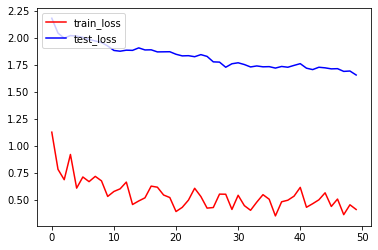

In [ ]:
# Visualise train / Valid Loss
plt.plot(model.history.history["loss"], c="r", label="train_loss")
plt.plot(model.history.history["val_loss"], c="b", label="test_loss")
plt.legend(loc="upper left")
plt.show()

define the model and class weights to help the model learn from the imbalanced data.